<a href="https://colab.research.google.com/github/Joseph-A-Mason/Colab_notebooks/blob/main/N_America_ee_filmstrip_gif.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook makes an animated GIF image from an Earth Engine time series image collection. A filmstrip is created that is chopped into frames. The frames are annotated with the image date according to text position and style you define. The resulting frames are combined into an animated GIF file using the image magick utility. The final step optionally compresses the GIF.This notebook makes an animated GIF image from an Earth Engine time series image collection. It  is a modified version of a notebook by Justin Braaten (https://github.com/jdbcode); I have modified the long code block that selects data, overlays images on a shaded relief map, adds dates, etc.

Set up Earth Engine

Develop the image collection. First gets a continent shapefile to allow the hillshade to be clipped to land areas. Adds line marking coasts. Then gets hillshade (from MERIT 3 arc second DEM) and clips it. Finally gets MODIS EVI and blends with hillshade and coast lines.

Setting the date in the `visImg` function is important!

`.set('date', img.date().format('YYYY-MM-dd', tz)))`

In [ ]:
import ee
ee.Authenticate()
ee.Initialize(project='aeol-masonja')

EEException: Google Earth Engine API has not been used in project 522309567947 before or it is disabled. Enable it by visiting https://console.developers.google.com/apis/api/earthengine.googleapis.com/overview?project=522309567947 then retry. If you enabled this API recently, wait a few minutes for the action to propagate to our systems and retry.

In [ ]:
region = ee.Geometry.Polygon(
  [[[-135.0, 14.0],
    [-66.0, 14.0],
    [-66.0, 77.0],
    [-135.0, 77.0]]],
    None, False)

coasts = ee.FeatureCollection('projects/aeol-masonja/assets/World_Continents')
coasts_outline = (ee.Image().byte()
  .paint(**{'featureCollection': coasts, 'color': 1, 'width': 1})
  .visualize(**{'palette': 'grey'}))

hillshade = ee.Terrain.hillshade(ee.Image('MERIT/DEM/v1_0_3')
  .multiply(100)
  .clipToCollection(coasts))

vis_params = {
  'min': 0.0,
  'max': 8000.0,
  'palette': [
    'FFFFFF', 'CE7E45', 'DF923D', 'F1B555', 'FCD163', '99B718', '74A901',
    '66A000', '529400', '3E8601', '207401', '056201', '004C00', '023B01',
    '012E01', '011D01', '011301'
  ],
};

dataset = (ee.ImageCollection('MODIS/006/MOD13A1')
  .filterDate(ee.Date('2019-01-01'), ee.Date('2021-12-31'))
  .select('EVI'))

def visImg(img):
    return (img.resample('bicubic')
      .visualize(**vis_params)
      .blend(coasts_outline)
      .blend(hillshade.visualize(**{'opacity':0.4}))
      .set('date', img.date().format('YYYY-MM-dd')))

dataset = (ee.ImageCollection.fromImages(
  dataset.toList(dataset.size()).slice(0, dataset.size(), 1))
  .map(visImg))

dates = dataset.aggregate_array('date').getInfo()



Generate a thumbnail filmstrip URL from the image collection. EPSG needs to change with region of the world. Can reduce width (720) if there is a message that the data request is too large.

In [ ]:
filmstrip_params = {
  'dimensions': 360,
  'region': region,
  'crs': 'EPSG:5070',
  'framesPerSecond': 0.5
}

filmstrip_url = dataset.getFilmstripThumbURL(filmstrip_params)

Get some packages and modules for dealing with images

In [ ]:
import urllib.request
from PIL import Image, ImageDraw, ImageFont
import glob
from IPython.display import Image as ImageGIF

Fetch the image collection thumbnail filmstrip

In [ ]:
filmstrip_name = 'filmstrip.png'
urllib.request.urlretrieve(filmstrip_url, filmstrip_name)

('filmstrip.png', <http.client.HTTPMessage at 0x7f6b56a59910>)

Get some info about the filmstrip

In [ ]:
filmstrip_im = Image.open(filmstrip_name)
width, height = filmstrip_im.size
crop_interval = height / len(dates)
print(width, height, crop_interval)

360 21942 318.0


Preview the first frame

<PIL.Image.Image image mode=RGBA size=360x318 at 0x7F6B56E80D50>


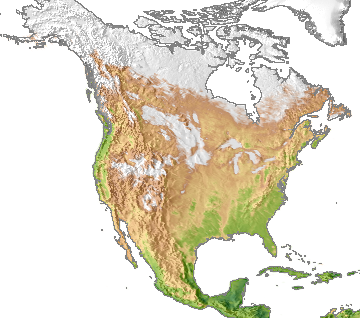

In [ ]:
frame_0 = filmstrip_im.crop((0, 0, width, crop_interval))
print(frame_0)
display(frame_0)

Get a font (Consolas)

In [ ]:
font_url = 'https://github.com/tsenart/sight/raw/master/fonts/Consolas.ttf'
font_name = 'Consolas.ttf'
urllib.request.urlretrieve(font_url, font_name)

('Consolas.ttf', <http.client.HTTPMessage at 0x7f6b56293710>)

Figure out annotation position and size

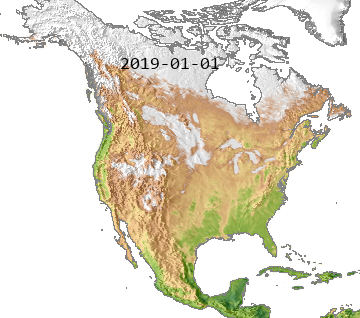

In [ ]:
right = 120
down = 55
font_size = 18
fill = '#000'

font = ImageFont.truetype(font_name, font_size)
anno_test = filmstrip_im.crop((0, 0, width, crop_interval))
ImageDraw.Draw(anno_test).text((right, down), dates[0], fill=fill, font=font)
display(anno_test)

Loop through the frames to crop and annotate

In [ ]:
for frame, date in enumerate(dates):
    frame_im = filmstrip_im.crop(
        (0, frame*crop_interval, width, (frame+1)*crop_interval))
    ImageDraw.Draw(frame_im).text((right, down), date, fill=fill, font=font)
    frame_im.save(str(frame).zfill(3)+'_frame.png')

Did it work?

Found these frames:

000_frame.png  014_frame.png  028_frame.png  042_frame.png  056_frame.png
001_frame.png  015_frame.png  029_frame.png  043_frame.png  057_frame.png
002_frame.png  016_frame.png  030_frame.png  044_frame.png  058_frame.png
003_frame.png  017_frame.png  031_frame.png  045_frame.png  059_frame.png
004_frame.png  018_frame.png  032_frame.png  046_frame.png  060_frame.png
005_frame.png  019_frame.png  033_frame.png  047_frame.png  061_frame.png
006_frame.png  020_frame.png  034_frame.png  048_frame.png  062_frame.png
007_frame.png  021_frame.png  035_frame.png  049_frame.png  063_frame.png
008_frame.png  022_frame.png  036_frame.png  050_frame.png  064_frame.png
009_frame.png  023_frame.png  037_frame.png  051_frame.png  065_frame.png
010_frame.png  024_frame.png  038_frame.png  052_frame.png  066_frame.png
011_frame.png  025_frame.png  039_frame.png  053_frame.png  067_frame.png
012_frame.png  026_frame.png  040_frame.png  054_frame.png  068_frame.png
013_frame.png  02

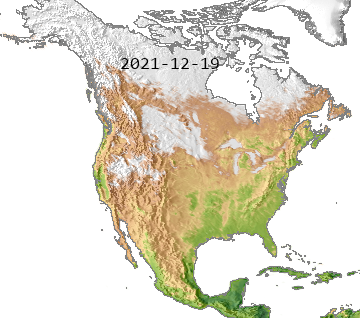

In [ ]:
print('Found these frames:\n')
!ls *_frame.png
print('\nFinal frame:\n')
Image.open(str(frame).zfill(3)+'_frame.png')

Make the GIF using ImageMagick

In [ ]:
!apt install imagemagick

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  fonts-droid-fallback fonts-noto-mono ghostscript gsfonts
  imagemagick-6-common imagemagick-6.q16 libcupsfilters1 libcupsimage2
  libdjvulibre-text libdjvulibre21 libgs9 libgs9-common libijs-0.35
  libjbig2dec0 liblqr-1-0 libmagickcore-6.q16-3 libmagickcore-6.q16-3-extra
  libmagickwand-6.q16-3 libnetpbm10 libwmf0.2-7 netpbm poppler-data
Suggested packages:
  fonts-noto ghostscript-x imagemagick-doc autotrace cups-bsd | lpr | lprng
  enscript gimp gnuplot grads hp2xx html2ps libwmf-bin mplayer povray radiance
  sane-utils texlive-base-bin transfig ufraw-batch inkscape libjxr-tools
  libwmf0.2-7-gtk poppler-utils fonts-japanese-mincho | fonts-ipafont-mincho
  fonts-japanese-gothic | fonts-ipafont-gothic fo

In [ ]:
import os

In [ ]:
gif_name = 'NAmer_EVIsm.gif'
delay = 20

cmd = f'convert -loop 0 -delay {delay} *_frame.png {gif_name}'
print(cmd)
os.system(cmd)

convert -loop 0 -delay 20 *_frame.png NAmer_EVIsm.gif


0

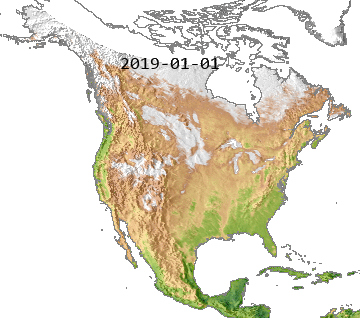

In [ ]:
with open('NAmer_EVIsm.gif','rb') as f:
    display(ImageGIF(data=f.read(), format='png'))

Compress the GIF

In [ ]:
in_gif = 'NAmer_EVIsm.gif'
out_gif = 'NAmer_EVIsm_compress.gif'
fuzz = 5  # percent

cmd = f'convert -fuzz {fuzz}% -layers Optimize {in_gif} {out_gif}'
print(cmd)
os.system(cmd)

convert -fuzz 5% -layers Optimize NAmer_EVIsm.gif NAmer_EVIsm_compress.gif


0

Preview the compressed version

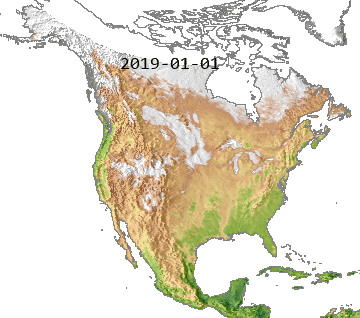

In [ ]:
with open('NAmer_EVIsm_compress.gif','rb') as f:
    display(ImageGIF(data=f.read(), format='png'))

Download the animation

In [ ]:
from google.colab import files
files.download(out_gif)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>